In [10]:
import librosa
import soundfile
import os, glob, pickle
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.neural_network import MLPClassifier
import sys
import wave
import struct
from scipy import signal
from itertools import chain
from numpy import *
from scipy import *
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
from sklearn.metrics import accuracy_score,recall_score,precision_score,f1_score
from sklearn.metrics import multilabel_confusion_matrix
from sklearn.model_selection import learning_curve
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.model_selection import GridSearchCV

import pyaudio
from sys import byteorder
from array import array
from struct import pack
from sklearn.ensemble import GradientBoostingClassifier, BaggingClassifier

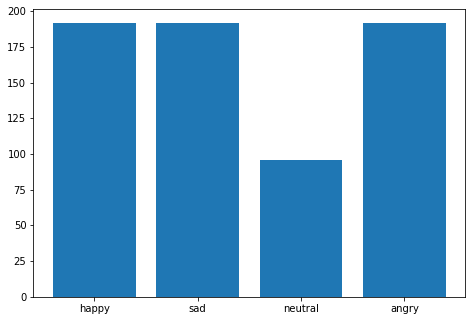

In [38]:
fig = plt.figure()
ax = fig.add_axes([0,0,1,1])
emotions = ['happy', 'sad', 'neutral', 'angry']
data = [192,192,96,192]
ax.bar(emotions,data)
plt.show()

In [11]:
#DataFlair - Extract features (mfcc, chroma, mel) from a sound file
def extract_feature(file_name, mfcc, chroma, mel):
    with soundfile.SoundFile(file_name) as sound_file:
        X = sound_file.read(dtype="float32")
        sample_rate=sound_file.samplerate
        if chroma:
            stft=np.abs(librosa.stft(X))
        result=np.array([])
        if mfcc:
            mfccs=np.mean(librosa.feature.mfcc(y=X, sr=sample_rate, n_mfcc=40).T, axis=0)
            result=np.hstack((result, mfccs))
        if chroma:
            chroma=np.mean(librosa.feature.chroma_stft(S=stft, sr=sample_rate).T,axis=0)
            result=np.hstack((result, chroma))
        if mel:
            mel=np.mean(librosa.feature.melspectrogram(X, sr=sample_rate).T,axis=0)
            result=np.hstack((result, mel))
        result=np.hstack((result,decision(file_name)))
    return result

In [12]:
def readWaveFile(fileName):
    waveFile = wave.open(fileName,'r')
    channels = waveFile.getnchannels()
    sampWidth = waveFile.getsampwidth()
    framesNumber = waveFile.getnframes()
    frameRate = waveFile.getframerate()
    frames = waveFile.readframes(framesNumber)
    data = struct.unpack("%dh" %  channels*framesNumber, frames)
    oneChannelData = data[::channels]
    oneChannelData = list(chain(oneChannelData))
    framesNumber = len(oneChannelData)
    waveFile.close()
    return oneChannelData, channels, sampWidth, frameRate, framesNumber

In [13]:
def getFreq(data,framesNumber,frameRate):
    time = float(framesNumber) / frameRate
    data = data * signal.nuttall(framesNumber)
    dataFFT = fft(data)
    absFFT = abs(dataFFT)
    logAbsFFT = np.log(absFFT)
    hps = copy(logAbsFFT)
    for h in np.arange(2, 6):
        decim = signal.decimate(logAbsFFT, int(h))
        hps[:len(decim)] += decim
    start = 150
    peak = np.argmax(hps[start::])
    fundamental = ((start+peak)/time)
    return fundamental

In [14]:
a=0
b=0
c=0
def decision(file_name):
    data, channels, sampwidth, frameRate, framesNumber = readWaveFile(file_name)
    freq = getFreq(data, framesNumber, frameRate)
    global a
    global b
    if freq>200:
        a=a+1
        return [1]
    else:
        b=b+1
        return [-1]

In [15]:
#DataFlair - Emotions in the RAVDESS dataset
emotions={
  '01':'neutral',
  '02':'calm',
  '03':'happy',
  '04':'sad',
  '05':'angry',
  '06':'fearful',
  '07':'disgust',
  '08':'surprised'
}
#DataFlair - Emotions to observe
observed_emotions=['neutral', 'happy', 'sad', 'angry']

In [16]:
#DataFlair - Load the data and extract features for each sound file
def load_data(test_size=0.15):
    x,y=[],[]
    global c
    for file in glob.glob("C:\\Users\\hp\\Documents\\Study Material\\OE-DM\\Speech-Emotion-Recogniser\\speech-emotion-recognition-ravdess-data\\Actor_*\\*.wav"):
        file_name=os.path.basename(file)
        emotion=emotions[file_name.split("-")[2]]
        if emotion not in observed_emotions:
            continue
        intensity = file_name.split("-")[3]
        gender= file_name.split("-")[6]
        #if int(intensity)== 2:
        #    continue
        feature=extract_feature(file, mfcc=True, chroma=True, mel=True)
        x.append(feature)
        y.append(emotion)
        #if c==0 or c==100 or c==200 or c==300 or c==400 or c==500 or c==600:
        #    print(feature[171:181])
        #    print(emotion, gender)
        c=c+1
    #return (np.array(x),y)
    return train_test_split(np.array(x), y, test_size=test_size, train_size= 0.85, random_state=9)

In [17]:
#DataFlair - Split the dataset
x_train,x_test,y_train,y_test=load_data(test_size=0.15)

C:\Users\hp\anaconda3\lib\site-packages\scipy\signal\_arraytools.py:45: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  b = a[a_slice]
C:\Users\hp\anaconda3\lib\site-packages\scipy\signal\signaltools.py:3463: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return y[sl]


In [18]:
#DataFlair - Get the shape of the training and testing datasets
print((x_train.shape[0], x_test.shape[0]))

(571, 101)


In [19]:
#DataFlair - Get the number of features extracted
print(f'Features extracted: {x_train.shape[1]}')

Features extracted: 181


In [30]:
#DataFlair - Initialize the Multi Layer Perceptron Classifier
model=MLPClassifier(activation= 'logistic', solver= 'adam', alpha=0.001, batch_size=32, epsilon=1e-08, hidden_layer_sizes=(500,), learning_rate='adaptive', max_iter=1000)

In [31]:
#DataFlair - Train the model
model.fit(x_train,y_train)

MLPClassifier(activation='logistic', alpha=0.001, batch_size=32,
              hidden_layer_sizes=(500,), learning_rate='adaptive',
              max_iter=1000)

In [32]:
#DataFlair - Predict for the test set
y_pred=model.predict(x_test)

In [33]:
#DataFlair - Calculate the accuracy of our model
accuracy=accuracy_score(y_true=y_test, y_pred=y_pred)
#DataFlair - Print the accuracy
print("Accuracy: {:.2f}%".format(accuracy*100))

Accuracy: 75.25%


In [24]:
print('Accuracy Score : ' + str(accuracy_score(y_test,y_pred)))
print('Precision Score : ' + str(precision_score(y_test,y_pred,average='micro')))
#print('Recall Score : ' + str(recall_score(y_test,y_pred), average='micro'))
#print('F1 Score : ' + str(f1_score(y_test,y_pred))
print(str(multilabel_confusion_matrix(y_test, y_pred, labels=['neutral', 'happy', 'sad', 'angry'])))
print(a,b)

Accuracy Score : 0.7524752475247525
Precision Score : 0.7524752475247525
[[[82  2]
  [ 6 11]]

 [[64  8]
  [ 7 22]]

 [[62 10]
  [ 7 22]]

 [[70  5]
  [ 5 21]]]
367 305


In [25]:
#Manualtesting
xtest=[]
files= "C:\\Users\\hp\\Documents\\Study Material\\OE-DM\\Speech-Emotion-Recogniser\\speech-emotion-recognition-ravdess-data\\Actor_08\\03-01-07-01-01-01-08.wav"
features= extract_feature(files, mfcc=True, chroma=True, mel=True)
xtest.append(features)
predict= model.predict(xtest)

C:\Users\hp\anaconda3\lib\site-packages\scipy\signal\_arraytools.py:45: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  b = a[a_slice]
C:\Users\hp\anaconda3\lib\site-packages\scipy\signal\signaltools.py:3463: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return y[sl]


In [26]:
print(predict)

['sad']


In [27]:
THRESHOLD = 500
CHUNK_SIZE = 1024
FORMAT = pyaudio.paInt16
RATE = 16000
SILENCE = 30

def is_silent(snd_data):
    "Returns 'True' if below the 'silent' threshold"
    return max(snd_data) < THRESHOLD

def normalize(snd_data):
    "Average the volume out"
    MAXIMUM = 16384
    times = float(MAXIMUM)/max(abs(i) for i in snd_data)
    r = array('h')
    for i in snd_data:
        r.append(int(i*times))
    return r

def trim(snd_data):
    "Trim the blank spots at the start and end"
    def _trim(snd_data):
        snd_started = False
        r = array('h')
        for i in snd_data:
            if not snd_started and abs(i)>THRESHOLD:
                snd_started = True
                r.append(i)

            elif snd_started:
                r.append(i)
        return r
    
    # Trim to the left
    snd_data = _trim(snd_data)
    # Trim to the right
    snd_data.reverse()
    snd_data = _trim(snd_data)
    snd_data.reverse()
    return snd_data

def add_silence(snd_data, seconds):
    "Add silence to the start and end of 'snd_data' of length 'seconds' (float)"
    r = array('h', [0 for i in range(int(seconds*RATE))])
    r.extend(snd_data)
    r.extend([0 for i in range(int(seconds*RATE))])
    return r

def record():
    """
    Record a word or words from the microphone and 
    return the data as an array of signed shorts.
    Normalizes the audio, trims silence from the 
    start and end, and pads with 0.5 seconds of 
    blank sound to make sure VLC et al can play 
    it without getting chopped off.
    """
    p = pyaudio.PyAudio()
    stream = p.open(format=FORMAT, channels=1, rate=RATE,
        input=True, output=True,
        frames_per_buffer=CHUNK_SIZE)

    num_silent = 0
    snd_started = False

    r = array('h')

    while 1:
        # little endian, signed short
        snd_data = array('h', stream.read(CHUNK_SIZE))
        if byteorder == 'big':
            snd_data.byteswap()
        r.extend(snd_data)

        silent = is_silent(snd_data)

        if silent and snd_started:
            num_silent += 1
        elif not silent and not snd_started:
            snd_started = True

        if snd_started and num_silent > SILENCE:
            break

    sample_width = p.get_sample_size(FORMAT)
    stream.stop_stream()
    stream.close()
    p.terminate()
    r = normalize(r)
    r = trim(r)
    r = add_silence(r, 0.5)
    return sample_width, r

def record_to_file(path):
    "Records from the microphone and outputs the resulting data to 'path'"
    sample_width, data = record()
    data = pack('<' + ('h'*len(data)), *data)
    wf = wave.open(path, 'wb')
    wf.setnchannels(1)
    wf.setsampwidth(sample_width)
    wf.setframerate(RATE)
    wf.writeframes(data)
    wf.close()

In [217]:
#livetesting
print("Please talk")
filename = "C:\\Users\\hp\\Music\\test3.wav"
record_to_file(filename)
#result = detector.predict(filename)
#print(result)

Please talk


In [28]:
xtest2=[]
files= "C:\\Users\\hp\\Music\\test2.wav"
features= extract_feature(files, mfcc=True, chroma=True, mel=True)
xtest2.append(features)
predict= model.predict(xtest2)

C:\Users\hp\anaconda3\lib\site-packages\scipy\signal\_arraytools.py:45: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  b = a[a_slice]
C:\Users\hp\anaconda3\lib\site-packages\scipy\signal\signaltools.py:3463: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return y[sl]


In [29]:
print(predict)

['sad']
